# DL Indaba Practical 5
# Variational Auto-Encoders

**Background**

In this practical, our only aim is for you to understand what a variational auto-encoder (VAE) is. Some people prefer to call it "auto-encoding variational Bayes", which is technically more correct.

If you are mathematically inclined, you are welcome to look at https://arxiv.org/pdf/1312.6114.pdf, but it is not neccessary for the scope of this practical.

**What is expected of you?**

1. Run through all the cells below, in order, and consider the output. You should see a loss that becomes smaller and smaller, and some images that will, over time, start resembling MNIST digits.
2. Step through the cells again, top to bottom. As you do this, try to answer all the questions as they arise.



In [0]:
import itertools
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import time

from matplotlib import pyplot as plt

import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

sg = tf.contrib.bayesflow.stochastic_graph
st = tf.contrib.bayesflow.stochastic_tensor
distributions = tf.contrib.distributions


In [0]:
tf.reset_default_graph()

try:
  flags = tf.app.flags
  flags.DEFINE_string('data_dir', '/tmp/dat/', 'Directory for data')
  flags.DEFINE_string('logdir', '/tmp/log/', 'Directory for logs')

  flags.DEFINE_integer('latent_dim', 100, 'Latent dimensionality of model')
  flags.DEFINE_integer('batch_size', 64, 'Minibatch size')
  flags.DEFINE_integer('n_samples', 1, 'Number of samples to save')
  flags.DEFINE_integer('print_every', 1000, 'Print every n iterations')
  flags.DEFINE_integer('hidden_size', 200, 'Hidden size for neural networks')
  # flags.DEFINE_integer('n_iterations', 1, 'number of iterations')
except:
  pass

FLAGS = flags.FLAGS

# Flags are immutable once defined. If you were to ever run big experiments,
# you'd use something like FLAGS.n_iterations, but as you want to try things in
# the cells below, we'll just make n_iterations something that you can change
# to easily re-run.

N_ITERATIONS = 10000


Before continuing, you'll have to sharpen your mental mathematical pencils, and step through a derivation.

# An "evidence lower bound"

"Evidence? Of what?," you might ask. Bayes's theorem states that

\begin{align}
p_{\theta}(z|x) & = \frac{p_{\theta}(z|x) \, p(z)}{p_{\theta}(x)} \\
\textrm{posterior} & = \frac{\textrm{likelihood} \times \textrm{prior}}{\textrm{evidence (or marginal likelihood)}}
\end{align}

and the denominator is an average of the likelihood over all prior assignments of $z$. Of course we can't compute it in most cases, and will find a way to approximate it as best we could.

**What would we like to optimize?**

We would like to optimize $\log p_{\theta}(x)$ over $\theta$. It's the best description of the data, averaged over all prior settings of $z$. But we cannot compute it. Oh dear!

**A lower bound, a.k.a. "sensible approximations rock!"**

For every data point (or MNIST image) $x$, we define the bound on the log marginal likelihood as:

\begin{align}
\log p_{\theta}(x) & = \log \int p_{\theta}(x, z) \, \mathrm{d} z \\
& = \log \int p_{\theta}(x | z) \, p(z) \, \mathrm{d} z \\
& = \log \int q_{\phi}(z | x) \left[ \frac{ p_{\theta}(x | z) \, p(z) }{q_{\phi}(z | x)} \right] \mathrm{d} z \\
& \ge \int q_{\phi}(z | x) \log \left[ \frac{ p_{\theta}(x | z) \, p(z) }{q_{\phi}(z | x)} \right] \mathrm{d} z \\
& = \mathbb{E}_{q_{\phi}(z|x)}\Big[ \log p_{\theta}(x | z) + \log p(z) - \log q_{\phi}(z | x)\Big] \\
& \equiv \mathcal{L}
\end{align}

We have a few pieces:
1. The likelihood $p_{\theta}(x | z)$, also called the "generative network". It is sometimes called the "decoder" as it "decodes" $x$ from $z$.
2. The variational approximation $q_{\phi}(z | x)$, also called the "inference network". Sometimes it is called the "encoder", as it "encodes" $x$ into $z$.

In the code below, we are going to define $p_{\theta}(x | z)$ and $q_{\phi}(z | x)$.

**Take a breather**

Explain to your neighbour what is going on here. Is there anything that you don't understand?

**Deep dive 101**

Your challenge is to find how $\theta$ and $\phi$ are represented in the code.
1. What are they?
2. Where are they?
Try to answer the other questions in the code below.

Note that in the code, there are many images $x$ that are stacked in a batch x. The bound refers to one such image, and we assume that they are generated i.i.d., we sum the bounds...

In [0]:
def inference_network(x, latent_dim, hidden_size):
  """Construct an inference network q(z|x).

  Args:
    x: A batch of MNIST digits.
    latent_dim: The latent dimensionality of z.
    hidden_size: The size of the neural net hidden layers.
  Returns:
    mu: The mean of q(z|x)
    sigma: The component-wise standard deviation of q(z|x)
  """  
  
  # Question: What is the shape of x as you run the code with MNIST images?  
  # Answer: It has shape (batch_size, 28, 28, 1).

  with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
    net = slim.flatten(x)    
    
    # Question: Now that we've flattened x, what is its shape now, as `net`?
    # Hint: You might have to put a `print(net.get_shape())` somewhere around
    #       here, run the `train()` cell to contruct the TF graph, and see what
    #       you get. Debugging is part of life!
    # Answer: ...
    
    # At this point, `net` contains the input to the network. We will now
    # transform it layer-by-layer:
    
    net = slim.fully_connected(net, hidden_size)
    
    # Question: What is the shape of the first layer, as `net`?
    # Answer: ...

    # Question: Write down the mathematical expression for
    #    net = slim.fully_connected(net, hidden_size). It it was not wrapped in
    #    "with slim.arg_scope(..., activation_fn=tf.nn.relu)", would the
    #    mathematical expression look different? Why?
    # Answer: ...
    
    net = slim.fully_connected(net, hidden_size)
    
    # Question: What is the shape of the second layer, as `net`?
    # Answer: ...
    
    gaussian_params = slim.fully_connected(
        net, latent_dim * 2, activation_fn=None)
    
    # Question: What is the shape of the third (output) layer,
    #    `gaussian_params`?    
    # Answer: ...
  
  # We're taking the output of the MLP (multi-layer perceptron) and split it
  # into two parts: the first latent_dim outputs become the means, while the
  # second latent_dim outputs become the standard deviations.
  
  # Challenge 1. Can you write the entire network as a mathematical function?
  # Challenge 2. Can you draw it?
  # Challenge 3. Can you say which parameters constitute \phi?
  #
  # Challenge 4. (You can skip this challenge and do it at home).
  #              Can you see it in the actual computation graph?
  #              Hint: You can write the graph to file with
  #
  #              tf.train.write_graph(tf.get_default_graph().as_graph_def(),
  #                                   directory, 'mygraph.pbtxt')
  
  # The mean parameter is unconstrained
  mu = gaussian_params[:, :latent_dim]
  
  # The standard deviation must be positive. Parametrize with a softplus and
  # add a small epsilon for numerical stability
  sigma = 1e-6 + tf.nn.softplus(gaussian_params[:, latent_dim:])
    
  # Question: Can you draw the softplus function, log(exp(inputs) + 1)?
  # Answer: ...

  return mu, sigma


def generative_network(z, hidden_size):
  """Build a generative network to return the logits of p(x|z).

  Args:
    z: Samples of latent variables.
    hidden_size: Size of the hidden state of the neural net.

  Returns:
    bernoulli_logits: logits for the Bernoulli likelihood of the data.
  """
  with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
    
    net = slim.fully_connected(z, hidden_size)
    net = slim.fully_connected(net, hidden_size)
    bernoulli_logits = slim.fully_connected(net, 784, activation_fn=None)
    bernoulli_logits = tf.reshape(bernoulli_logits, [-1, 28, 28, 1])
    
    # Challenge 5. Can you again write the entire network as a mathematical
    #              function, draw it, and say which parameters constitute
    #              \theta?
    
    # Hold that thought... Can you (later) say why "logits" are returned, and
    # why the are not transformed here to a probability?
  return bernoulli_logits

Now, look for the line `q_z = st.StochasticTensor(distributions.Normal(loc=q_mu, scale=q_sigma))` in `train()`.

**Your challenge will be to rewrite that line, so that `st.StochasticTensor(...)` is not used.**

First of all, you need to know what it does.
Here, you will encounter the **reparameterization trick**. This rewrites:

\begin{align}
\mathcal{L} & = \mathbb{E}_{q_{\phi}(z|x)}\Big[ \log p_{\theta}(x | z) + \log p(z) - \log q_{\phi}(z | x)\Big] \\
& = \mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\Big[ \log p_{\theta}(x | z) \Big]
- \mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\left[ \log \frac{ q_{\phi}(z | x) }{p(z)} \right] \\
& = \mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\Big[ \log p_{\theta}(x | z) \Big]
- \textrm{Kullback Leibler divergence} \ .
\end{align}

You can turn to your favourite souce, and find an expression for the KL divergence:
https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence ... It is function of a mean $\mu_{\theta}(x)$ and variance $\sigma^2_{\theta}(x)$, and we can look in Wikipedia on how to compute it.

Note that the mean $\mu_{\theta}(x)$ and variance $\sigma^2_{\theta}(x)$ are parameterized as multi-layer perceptrons (MLPs) in `def inference_network(x, latent_dim, hidden_size)`.

**Easy there, what's the catch?**

Well, we can write the KL divergence part as a function, that we can differentiate (thank you, TensorFlow! back in the day people had to do this by hand!). But what about the first expectation?

For the first expectation, we'd have to do something called a "Monte Carlo estimate" because we can't browse Wikipedia and look for a nice and analytic form of the function.

**Monte Carlo estimate**

Take $L$ samples $z^{(l)}$ from $z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))$, and call them $z^{(1)}, z^{(2)}, \ldots, z^{(L)}$. The "sampling process" essentially maps $x \to z$ stochastically. We now approximate

\begin{align}
\mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\Big[ \log p_{\theta}(x | z) \Big] \approx
\frac{1}{L} \sum_{l=1}^{L} \log p_{\theta}(x | z^{(l)}) \ .
\end{align}

This is really awesome, as the expression above maps back $z \to x$. Except for one small detail. If we were to write $x \to z \to x$ as a function, TensorFlow cannot differentiate it for us any more. We cannot take gradients through the samples :-( :-(

**Reparameterization trick**

There is a neat trick, where we put the samples (and stochasticity) *outside* the $x \to z \to x$ path.
The trick is to sample $L$ uniform Gaussian random variables $\epsilon^{(l)} \sim \mathcal{N}(0, 1)$. Can you see that there are no fancy parameters (that we have to adjust) in $\mathcal{N}(0, 1)$?

We can get the same samples from $z$, as we've had before, by *transforming* the $\mathcal{N}(0, 1)$ random variables:
$z^{(l)} = \mu_{\theta}(x) + \epsilon^{(l)} * \sigma_{\theta}(x)$.

\begin{align}
\mathbb{E}_{z \sim \mathcal{N}(\mu_{\theta}(x), \sigma^2_{\theta}(x))}\Big[ \log p_{\theta}(x | z) \Big]
= 
\mathbb{E}_{\epsilon \sim \mathcal{N}(0, 1)}\Big[ \log p_{\theta}\Big(x \, \Big| \, z = \mu_{\theta}(x) + \epsilon * \sigma_{\theta}(x)\Big) \Big]
\approx
\frac{1}{L} \sum_{l=1}^{L} \log p_{\theta}\Big(x \, \Big| \, z = \mu_{\theta}(x) + \epsilon^{(l)} * \sigma_{\theta}(x)\Big) \ .
\end{align}

Extracting /tmp/dat/train-images-idx3-ubyte.gz
Extracting /tmp/dat/train-labels-idx1-ubyte.gz
Extracting /tmp/dat/t10k-images-idx3-ubyte.gz
Extracting /tmp/dat/t10k-labels-idx1-ubyte.gz
Iteration: 0 ELBO: -525.469 Examples/s: 3.838e+06
Iteration: 100 ELBO: -188.745 Examples/s: 2.912e+07
Iteration: 200 ELBO: -168.964 Examples/s: 2.571e+07
Iteration: 300 ELBO: -159.560 Examples/s: 3.016e+07
Iteration: 400 ELBO: -152.453 Examples/s: 2.630e+07
Iteration: 500 ELBO: -153.275 Examples/s: 1.821e+07
Iteration: 600 ELBO: -158.503 Examples/s: 2.823e+07
Iteration: 700 ELBO: -147.464 Examples/s: 1.880e+07
Iteration: 800 ELBO: -143.465 Examples/s: 2.852e+07
Iteration: 900 ELBO: -142.685 Examples/s: 2.676e+07
Iteration: 1000 ELBO: -139.651 Examples/s: 2.301e+07


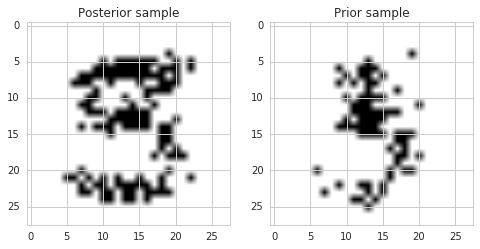

Iteration: 1100 ELBO: -130.515 Examples/s: 2.601e+07
Iteration: 1200 ELBO: -116.344 Examples/s: 3.022e+07
Iteration: 1300 ELBO: -127.545 Examples/s: 2.620e+07
Iteration: 1400 ELBO: -127.301 Examples/s: 2.342e+07
Iteration: 1500 ELBO: -119.417 Examples/s: 2.353e+07
Iteration: 1600 ELBO: -109.718 Examples/s: 2.321e+07
Iteration: 1700 ELBO: -111.823 Examples/s: 2.118e+07
Iteration: 1800 ELBO: -118.536 Examples/s: 2.449e+07
Iteration: 1900 ELBO: -113.231 Examples/s: 2.896e+07
Iteration: 2000 ELBO: -121.325 Examples/s: 2.407e+07


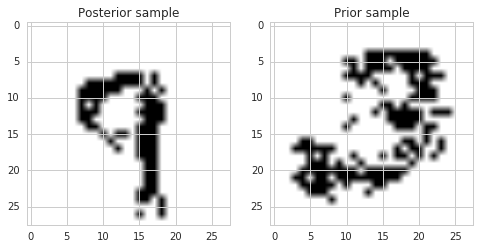

Iteration: 2100 ELBO: -110.871 Examples/s: 2.812e+07
Iteration: 2200 ELBO: -108.549 Examples/s: 2.910e+07
Iteration: 2300 ELBO: -105.549 Examples/s: 2.644e+07
Iteration: 2400 ELBO: -101.544 Examples/s: 2.881e+07
Iteration: 2500 ELBO: -115.490 Examples/s: 2.899e+07
Iteration: 2600 ELBO: -105.243 Examples/s: 2.828e+07
Iteration: 2700 ELBO: -108.784 Examples/s: 2.663e+07
Iteration: 2800 ELBO: -110.796 Examples/s: 2.958e+07
Iteration: 2900 ELBO: -103.006 Examples/s: 2.772e+07
Iteration: 3000 ELBO: -106.524 Examples/s: 2.438e+07


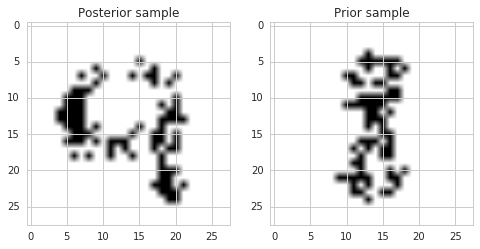

Iteration: 3100 ELBO: -99.276 Examples/s: 2.750e+07
Iteration: 3200 ELBO: -104.404 Examples/s: 2.708e+07
Iteration: 3300 ELBO: -101.351 Examples/s: 2.269e+07
Iteration: 3400 ELBO: -95.890 Examples/s: 2.131e+07
Iteration: 3500 ELBO: -103.034 Examples/s: 1.809e+07
Iteration: 3600 ELBO: -100.490 Examples/s: 2.531e+07
Iteration: 3700 ELBO: -101.901 Examples/s: 2.539e+07
Iteration: 3800 ELBO: -101.409 Examples/s: 2.585e+07
Iteration: 3900 ELBO: -96.984 Examples/s: 2.737e+07
Iteration: 4000 ELBO: -96.786 Examples/s: 2.113e+07


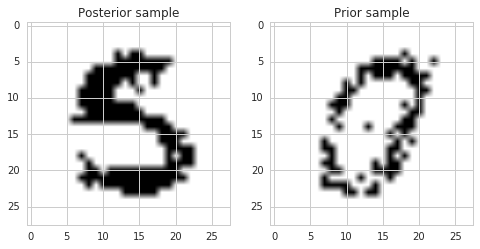

Iteration: 4100 ELBO: -100.557 Examples/s: 3.064e+07
Iteration: 4200 ELBO: -87.998 Examples/s: 2.750e+07
Iteration: 4300 ELBO: -101.873 Examples/s: 2.762e+07
Iteration: 4400 ELBO: -99.564 Examples/s: 2.643e+07
Iteration: 4500 ELBO: -93.480 Examples/s: 2.748e+07
Iteration: 4600 ELBO: -94.323 Examples/s: 2.707e+07
Iteration: 4700 ELBO: -90.013 Examples/s: 2.022e+07
Iteration: 4800 ELBO: -98.292 Examples/s: 2.947e+07
Iteration: 4900 ELBO: -96.864 Examples/s: 2.781e+07
Iteration: 5000 ELBO: -89.915 Examples/s: 1.871e+07


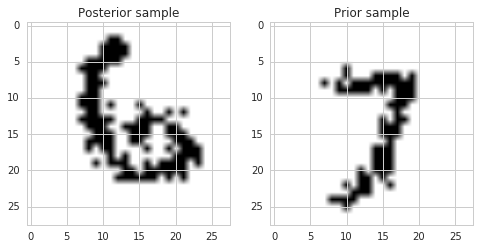

Iteration: 5100 ELBO: -89.134 Examples/s: 2.065e+07
Iteration: 5200 ELBO: -90.051 Examples/s: 2.478e+07
Iteration: 5300 ELBO: -96.362 Examples/s: 2.518e+07
Iteration: 5400 ELBO: -99.702 Examples/s: 2.258e+07
Iteration: 5500 ELBO: -89.069 Examples/s: 2.854e+07
Iteration: 5600 ELBO: -88.717 Examples/s: 2.396e+07
Iteration: 5700 ELBO: -97.497 Examples/s: 2.509e+07
Iteration: 5800 ELBO: -104.053 Examples/s: 2.823e+07
Iteration: 5900 ELBO: -96.331 Examples/s: 2.860e+07
Iteration: 6000 ELBO: -85.765 Examples/s: 2.791e+07


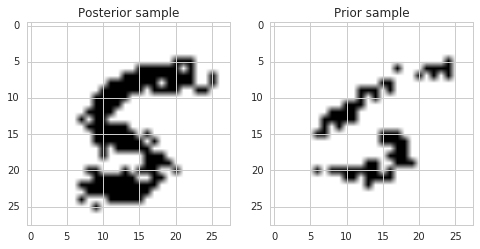

Iteration: 6100 ELBO: -89.428 Examples/s: 2.855e+07
Iteration: 6200 ELBO: -95.103 Examples/s: 2.906e+07
Iteration: 6300 ELBO: -97.478 Examples/s: 2.460e+07
Iteration: 6400 ELBO: -89.926 Examples/s: 1.949e+07
Iteration: 6500 ELBO: -100.856 Examples/s: 2.561e+07
Iteration: 6600 ELBO: -85.630 Examples/s: 2.550e+07
Iteration: 6700 ELBO: -89.295 Examples/s: 2.448e+07
Iteration: 6800 ELBO: -91.878 Examples/s: 2.194e+07
Iteration: 6900 ELBO: -95.814 Examples/s: 2.343e+07
Iteration: 7000 ELBO: -87.571 Examples/s: 2.595e+07


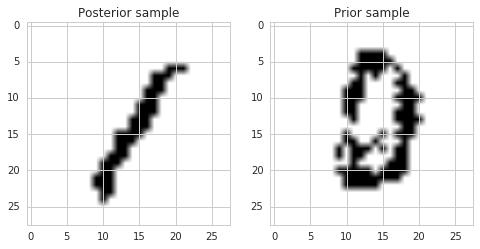

Iteration: 7100 ELBO: -89.632 Examples/s: 2.832e+07
Iteration: 7200 ELBO: -86.817 Examples/s: 2.456e+07
Iteration: 7300 ELBO: -89.888 Examples/s: 2.525e+07
Iteration: 7400 ELBO: -90.124 Examples/s: 2.819e+07
Iteration: 7500 ELBO: -87.920 Examples/s: 2.841e+07
Iteration: 7600 ELBO: -91.426 Examples/s: 3.000e+07
Iteration: 7700 ELBO: -92.654 Examples/s: 2.700e+07
Iteration: 7800 ELBO: -92.686 Examples/s: 2.748e+07
Iteration: 7900 ELBO: -94.766 Examples/s: 2.193e+07
Iteration: 8000 ELBO: -87.158 Examples/s: 2.433e+07


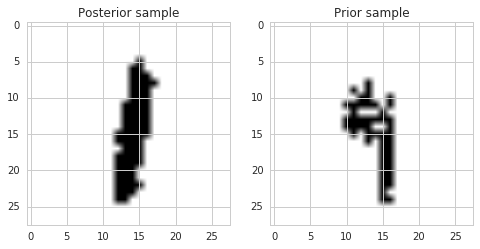

Iteration: 8100 ELBO: -90.209 Examples/s: 2.604e+07
Iteration: 8200 ELBO: -92.054 Examples/s: 2.306e+07
Iteration: 8300 ELBO: -84.296 Examples/s: 2.724e+07
Iteration: 8400 ELBO: -89.260 Examples/s: 2.708e+07
Iteration: 8500 ELBO: -94.538 Examples/s: 1.697e+07
Iteration: 8600 ELBO: -88.578 Examples/s: 2.605e+07
Iteration: 8700 ELBO: -89.822 Examples/s: 2.202e+07
Iteration: 8800 ELBO: -93.196 Examples/s: 2.523e+07
Iteration: 8900 ELBO: -90.424 Examples/s: 3.060e+07
Iteration: 9000 ELBO: -91.417 Examples/s: 2.660e+07


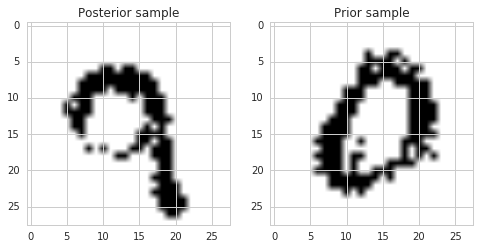

Iteration: 9100 ELBO: -94.702 Examples/s: 2.439e+07
Iteration: 9200 ELBO: -88.214 Examples/s: 2.225e+07
Iteration: 9300 ELBO: -87.940 Examples/s: 2.913e+07
Iteration: 9400 ELBO: -87.990 Examples/s: 2.566e+07
Iteration: 9500 ELBO: -90.145 Examples/s: 2.505e+07
Iteration: 9600 ELBO: -90.021 Examples/s: 2.266e+07
Iteration: 9700 ELBO: -89.089 Examples/s: 2.251e+07
Iteration: 9800 ELBO: -90.507 Examples/s: 2.493e+07
Iteration: 9900 ELBO: -90.916 Examples/s: 2.615e+07


In [0]:
def train():  
  # Train a Variational Autoencoder on MNIST

  # We need to reset the graph between multiple runs of the cell to avoid
  # TF complaining about creating duplicate variables.
  tf.reset_default_graph()
  
  # Input placeholders
  with tf.name_scope('data'):
    x = tf.placeholder(tf.float32, [None, 28, 28, 1])   
  
  with tf.variable_scope('variational'):
    # Given x, get the mean and variance of q(z|x).
    q_mu, q_sigma = inference_network(x=x,
                                      latent_dim=FLAGS.latent_dim,
                                      hidden_size=FLAGS.hidden_size)
    
    with st.value_type(st.SampleValue()):
      # We now draw a sample from z ~ q(z|x).
      #
      # This is the key to this practical. We effectively transform Normal(0,1)
      # noise that it *outside* the computation graph, to represent a sample
      # from Normal(q_mu, q_sigma).
      #
      #   This is the REPARAMETERIZATION TRICK.
      
      q_z = st.StochasticTensor(distributions.Normal(loc=q_mu, scale=q_sigma))
      
      # Challenge: Can you write
      #
      # q_z = ...
      #
      # by using tf.random_normal(...) and then transforming it?
      
  with tf.variable_scope('model'):
    # The likelihood is Bernoulli-distributed with logits given by the
    # generative network
    p_x_given_z_logits = generative_network(z=q_z,
                                            hidden_size=FLAGS.hidden_size)

    p_x_given_z = distributions.Bernoulli(logits=p_x_given_z_logits)
    
    posterior_predictive_samples = p_x_given_z.sample()

  # You can ignore the "Take samples" bits for now, until the end of the prac.
  # Take samples from the prior
  with tf.variable_scope('model', reuse=True):
    p_z = distributions.Normal(loc=np.zeros(FLAGS.latent_dim, dtype=np.float32),
                               scale=np.ones(FLAGS.latent_dim, dtype=np.float32))
    p_z_sample = p_z.sample(FLAGS.n_samples)
    p_x_given_z_logits = generative_network(z=p_z_sample,
                                            hidden_size=FLAGS.hidden_size)
    prior_predictive = distributions.Bernoulli(logits=p_x_given_z_logits)
    prior_predictive_samples = prior_predictive.sample()   

  # You can ignore the "Take samples" bits for now, until the end of the prac.
  # Take samples from the prior with a placeholder
  with tf.variable_scope('model', reuse=True):
    z_input = tf.placeholder(tf.float32, [None, FLAGS.latent_dim])
    p_x_given_z_logits = generative_network(z=z_input,
                                            hidden_size=FLAGS.hidden_size)
    prior_predictive_inp = distributions.Bernoulli(logits=p_x_given_z_logits)
    prior_predictive_inp_sample = prior_predictive_inp.sample()

  # The juice! Convince yourself that you understand the lines below.  
  # Build the evidence lower bound (ELBO) or the negative loss
  kl = tf.reduce_sum(distributions.kl_divergence(q_z.distribution, p_z), 1)
  expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x),
                                          [1, 2, 3])
  elbo = tf.reduce_sum(expected_log_likelihood - kl, 0)

  # Challenge. Can you see how the four lines above relate to the mathematical
  #            expressions you've encountered?
  # Answer: ...
  
  optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

  train_op = optimizer.minimize(-elbo)

  init_op = tf.global_variables_initializer()

  # Run training
  sess = tf.InteractiveSession()
  sess.run(init_op)
 
  #mnist = read_data_sets(FLAGS.data_dir, one_hot=True)
  mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)

  # Get fixed MNIST digits for plotting posterior means during training
  np_x_fixed, np_y = mnist.test.next_batch(5000)
  np_x_fixed = np_x_fixed.reshape(5000, 28, 28, 1)
  np_x_fixed = (np_x_fixed > 0.5).astype(np.float32)

  for i in range(N_ITERATIONS):
    # Re-binarize the data at every batch; this improves results
    np_x, _ = mnist.train.next_batch(FLAGS.batch_size)
    np_x = np_x.reshape(FLAGS.batch_size, 28, 28, 1)
    np_x = (np_x > 0.5).astype(np.float32)
    sess.run(train_op, {x: np_x})
        
    t0 = time.time()
    if i % 100 == 0:      
      np_elbo = sess.run(elbo, feed_dict={x: np_x})            
           
      print('Iteration: {0:d} ELBO: {1:.3f} Examples/s: {2:.3e}'.format(
          i,
          np_elbo / FLAGS.batch_size,
          FLAGS.batch_size * FLAGS.print_every / (time.time() - t0)))
      t0 = time.time()      

    if i % 1000 == 0 and i > 0: 
      # Get samples
      np_posterior_samples, np_prior_samples = sess.run(
          [posterior_predictive_samples, prior_predictive_samples],
          feed_dict={x: np_x})           
      
      for k in range(1):   # range(FLAGS.n_samples):        
        # Plot the data using Matplotlib
        fig = plt.figure()  
        plt.subplot(1, 2, 1)        
        plt.imshow(np_posterior_samples[k, :, :, 0])        
        plt.title('Posterior sample')        
        
        plt.subplot(1, 2, 2)        
        plt.imshow(np_prior_samples[k, :, :, 0])        
        plt.title('Prior sample')
        plt.show()                  

train()


# Acknowledgements

* Based on Jaan Altosaar's wonderful VAE implementation: https://github.com/altosaar/vae/blob/master/vae.py